# Importing libraries, loading and transforming data

In [1]:
!pip install ipywidgets

In [2]:
!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null
!pip install evaluate 2>/dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import gc  # For garbage collection to manage memory
import re  # For regular expressions
import numpy as np  # For numerical operations and arrays

import warnings  # For handling warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

import torch  # PyTorch library for deep learning
from transformers import AutoModel, AutoTokenizer  # Transformers library for natural language processing
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  # Transformers components for text processing
from transformers import AutoModelForSequenceClassification  # Transformer model for sequence classification

from nlp import Dataset  # Import custom 'Dataset' class for natural language processing tasks
from imblearn.over_sampling import RandomOverSampler  # For oversampling to handle class imbalance
import datasets  # Import datasets library
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import pipeline  # Transformers library for pipelines
from bs4 import BeautifulSoup  # For parsing HTML content

import matplotlib.pyplot as plt  # For data visualization
import itertools  # For working with iterators
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

import evaluate
#from datasets import load_metric  # Import load_metric function to load evaluation metrics

from tqdm import tqdm  # For displaying progress bars
tqdm.pandas()  # Enable progress bars for pandas operations

In [4]:
# Set parameters for training a news category classifier using DistilBERT

# Fraction of the dataset used for training, the rest will be used for validation
train_fraction = 0.8

# Number of training epochs
num_train_epochs = 5

# Learning rate
learning_rate = 3e-6

# Batch size for training
train_batch_size = 8

# Batch size for validation
eval_batch_size = 64

# Number of warm-up steps during training
warmup_steps = 50

# Weight decay to control regularization during training
weight_decay = 0.02

# Pre-trained BERT model to be used
BERT_MODEL = "distilbert-base-cased"

# Directory where the model output will be saved
output_dir = "email-spam-detection-distilbert"

In [5]:
%%time
# Read the CSV file into a DataFrame
df = pd.read_csv("/kaggle/input/email-spam-classification-dataset/combined_data.csv")

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

# select label as spam
def label_spam(x):
    if x > 0:
        return 'Spam'
    elif x == 0:
        return 'No spam'
df['label'] = df['label'].apply(label_spam)

df = df.rename(columns={'text': 'title'})  # Rename the columns to standard ones

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

There are 0 duplicates found in the dataset
(83448, 2)
CPU times: user 1.91 s, sys: 286 ms, total: 2.19 s
Wall time: 3.77 s


,27694,72430,17929,80233,72513
label,No spam,Spam,No spam,Spam,Spam
title,"state . . .\ngray david , loretta lynch , and ...",http imagecloset com uimages klzescapenumberv ...,i have a matrix of characters actually numbers...,see attachment http www huken hk ennis del mar...,first there is no online payment gateway payme...


In [6]:
# Class Imbalance is common in such datasets. Hence, computing class weights to adjusts for class imbalance
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df[['label']])
print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])
class_weights = dict(zip(classes, weights))
print(class_weights)

['No spam' 'Spam']
{'No spam': 1.0552885831352117, 'Spam': 0.9502163516283306}


In [7]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'No spam', 1: 'Spam'} 

Mapping of Labels to IDs: {'No spam': 0, 'Spam': 1}


In [8]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[1.0552885831352117, 0.9502163516283306]

In [9]:
# Create a dataset from the Pandas DataFrame 'df'
dataset = Dataset.from_pandas(df)

In [10]:
# Transforming dataset for training
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=1-train_fraction, shuffle=True, stratify_by_column="label")
df_train = dataset['train']
df_test = dataset['test']

Map:   0%|          | 0/83448 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/83448 [00:00<?, ? examples/s]

In [11]:
# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
gc.collect()

214

In [12]:
# Create a tokenizer instance for the specified BERT model.

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
# preprocessing data

def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/66758 [00:00<?, ? examples/s]

Map:   0%|          | 0/16690 [00:00<?, ? examples/s]

In [14]:
# Remove the 'title' column from the training and test dataset.
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [15]:
df_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 66758
})

In [16]:
df_test

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 16690
})

In [17]:
# DataCollatorWithPadding creates batch of data and add padding dynamically to the text

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
# Retrieve the 'input_ids' from the first row of the DataFrame 'df_train'
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] formulario : ( * ) informacin inscripcin diplomado : gestin comercio exterior participante : cargo : empresa : giro : direccin : comuna : telfono : fax : e - mail : ejecutiva : marta jacqueline melissa patricia otro ejecutivo socio asexma si no los campos que se encuentran con ( * ) son obligatorios para anular inscripciones : notificar por escrito antes de 48 horas del inicio del evento. de lo contrario, se considerar que la persona asiste y se tramitar el cobro correspondiente. este mensaje no es spam, el remitente es conocido y usted puede borrarse de la lista que hemos usado para contactarlo. si ya no quiere recibir m? s informaci? n de asexma chile, haga click aqu? y envie el correo que aparecera en algunos segundos. [SEP]'

# Loading and training model

In [19]:
# Load a pre-trained BERT-based model for sequence classification.
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=len(labels_list),
    output_attentions=False,  # Set to False: Model will not return attention weights.
    output_hidden_states=False  # Set to False: Model will not return all hidden-states.
)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label  # Mapping from label indices to class labels.
model.config.label2id = label2id  # Mapping from class labels to label indices.

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


65.783042


In [20]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

In [21]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weigths, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [22]:
# Create TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save the model checkpoints and logs
    logging_dir='./logs',  # Directory to store training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=train_batch_size,  # Batch size for training data
    per_device_eval_batch_size=eval_batch_size,  # Batch size for evaluation data
    logging_strategy='steps',  # Logging frequency during training (steps or epoch)
    logging_first_step=True,  # Log the first training step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every training step (useful for debugging)
    learning_rate=learning_rate, # Set the learning rate for the optimizer.
    evaluation_strategy='epoch',  # Evaluation frequency (epoch or steps)
    warmup_steps=warmup_steps,  # Number of warmup steps for the learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every training step (useful for debugging)
    save_strategy='epoch',  # Save model checkpoints every epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save space
    report_to="mlflow",  # Log training metrics to MLflow
)

# Define the trainer:
# Instantiate the trainer class and configure its settings
trainer = WeightedTrainer(
    model=model,  # The pretrained or custom model to be trained
    args=training_args,  # TrainingArguments for configuring training
    compute_metrics=compute_metrics,  # Function for computing evaluation metrics
    train_dataset=df_train,  # Training dataset
    eval_dataset=df_test,  # Evaluation dataset
    data_collator=data_collator  # Data collator for batching and preprocessing
)

In [23]:
# Get initial metrics
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7102800607681274,
 'eval_accuracy': 0.5261833433193529,
 'eval_runtime': 152.7446,
 'eval_samples_per_second': 109.267,
 'eval_steps_per_second': 1.709}

In [24]:
# Start training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000400,0.059425,0.987717
2,0.000300,0.057965,0.989515
3,0.000100,0.092137,0.984901
4,0.000000,0.065253,0.990413
5,0.000000,0.053021,0.992570


TrainOutput(global_step=41725, training_loss=0.04250765800945363, metrics={'train_runtime': 9963.6135, 'train_samples_per_second': 33.501, 'train_steps_per_second': 4.188, 'total_flos': 4.279153575153542e+16, 'train_loss': 0.04250765800945363, 'epoch': 5.0})

In [25]:
# Final model evaluation
trainer.evaluate()

{'eval_loss': 0.05302136763930321,
 'eval_accuracy': 0.9925704014379868,
 'eval_runtime': 154.3469,
 'eval_samples_per_second': 108.133,
 'eval_steps_per_second': 1.691,
 'epoch': 5.0}

In [26]:
# Use the trained 'trainer' to make predictions on the 'df_test'.
outputs = trainer.predict(df_test)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.05302136763930321, 'test_accuracy': 0.9925704014379868, 'test_runtime': 154.2422, 'test_samples_per_second': 108.206, 'test_steps_per_second': 1.692}


Accuracy: 0.9926
F1 Score: 0.9926


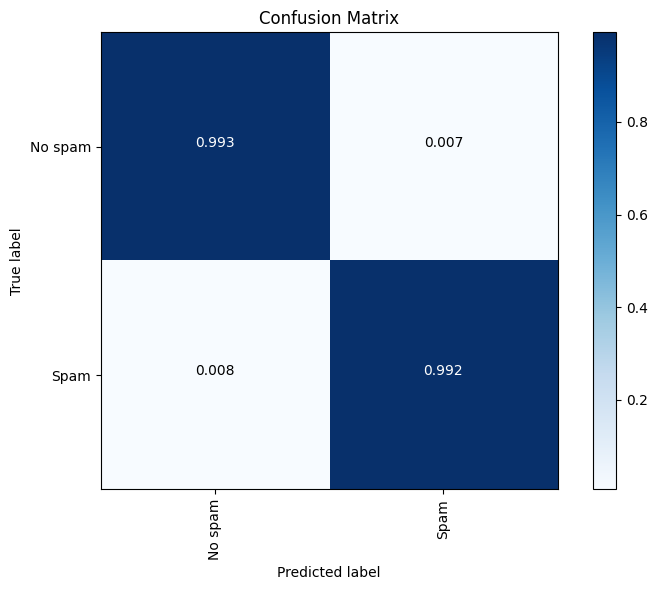


Classification report:

              precision    recall  f1-score   support

     No spam     0.9909    0.9934    0.9922      7908
        Spam     0.9941    0.9918    0.9929      8782

    accuracy                         0.9926     16690
   macro avg     0.9925    0.9926    0.9926     16690
weighted avg     0.9926    0.9926    0.9926     16690



In [27]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    

    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Saving the model and checking its performance with a sample input

In [28]:
trainer.save_model()

In [29]:
tokenizer.save_vocabulary(save_directory=f"./{output_dir}")

('./email-spam-detection-distilbert/vocab.txt',)

In [30]:
# Make a classification pipeline and test with the sample input
pipe = pipeline("text-classification", output_dir, tokenizer=BERT_MODEL)
sample_title = '''Elon Musk buys Twitter, and so can you'''
pipe(sample_title, top_k=10)

[{'label': 'Spam', 'score': 0.9999079704284668},
 {'label': 'No spam', 'score': 9.205426613334566e-05}]

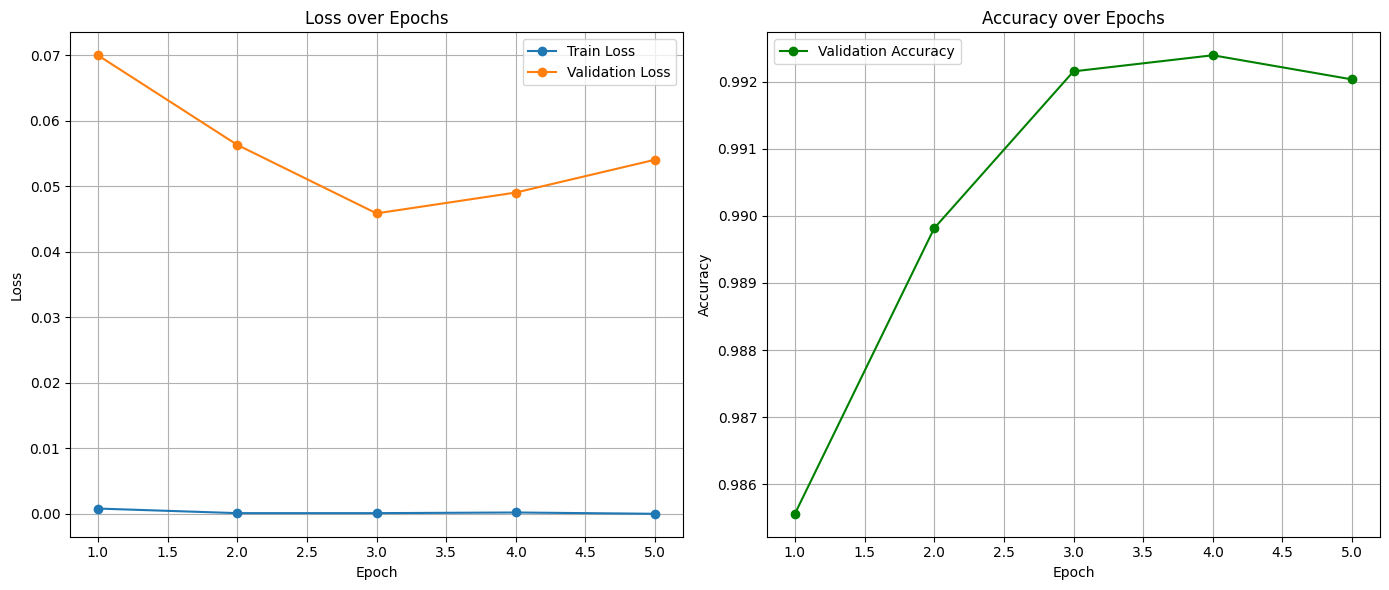

In [31]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [0.000800, 0.000100, 0.000100, 0.000200, 0.000000]
eval_loss = [0.069984, 0.056311, 0.045852, 0.049033, 0.054041]
eval_accuracy = [0.985560, 0.989814, 0.992151, 0.992391, 0.992031]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label='Validation Accuracy', color='green', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Explainability, Reducing AI Risks

In [ ]:
import shap

# Convert sparse matrix to dense
X_sample_dense = X_test_features[:5].toarray()

# Use LinearExplainer for LogisticRegression
explainer = shap.Explainer(model, X_train_features[:100].toarray())  # small background for performance
shap_values = explainer(X_sample_dense)


# Get TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()

# Get mean absolute SHAP values
import numpy as np
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame mapping feature indices to words
import pandas as pd
shap_df = pd.DataFrame({
    'Word': feature_names,
    'Mean SHAP Value': mean_shap_values
})

# Sort and display top 20 most influential words
shap_df_sorted = shap_df.sort_values(by='Mean SHAP Value', ascending=False).head(20)
print(shap_df_sorted)

# Plot top SHAP words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_sorted['Word'], shap_df_sorted['Mean SHAP Value'], color='orange')
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 20 Words Influencing Spam Classification")
plt.gca().invert_yaxis()
plt.show()

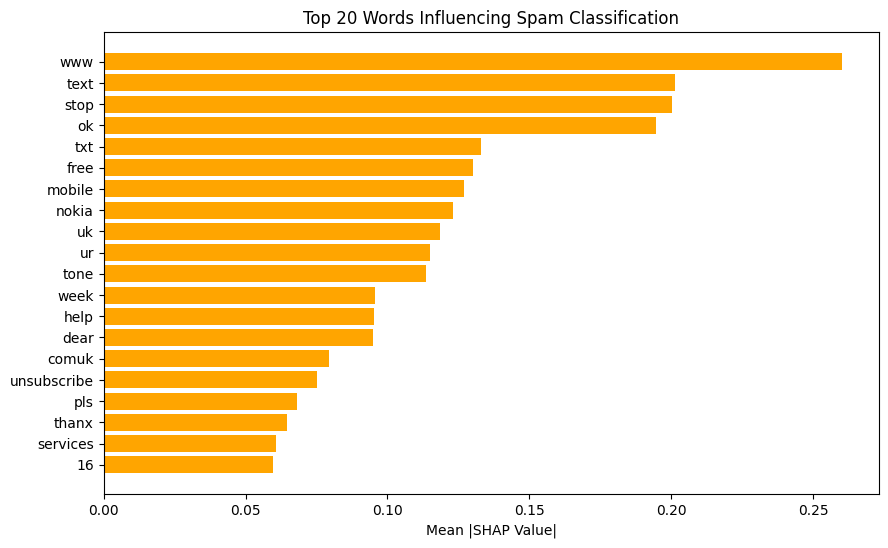